In [1]:
import numpy,sys,matplotlib,pandas
import scanpy

scanpy.settings.verbosity = 3
scanpy.settings.n_jobs=8
scanpy.logging.print_versions()

%matplotlib inline

scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.16.4 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


# 1. Read data

In [2]:
adata = scanpy.read_10x_mtx('/Volumes/omics4tb2/alomana/projects/i18/results/10x/aggregated/outs/filtered_feature_bc_matrix',var_names='gene_symbols',cache=True)
adata.var_names_make_unique() 

... reading from cache file cache/Volumes-omics4tb2-alomana-projects-i18-results-10x-aggregated-outs-filtered_feature_bc_matrix-matrix.h5ad


# 2. Quality control

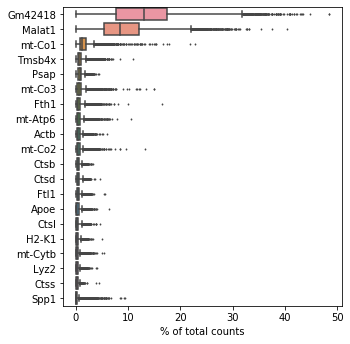

In [3]:
scanpy.pl.highest_expr_genes(adata, n_top=20)

In [4]:
scanpy.pp.filter_cells(adata, min_genes=200)
scanpy.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


filtered out 344 cells that have less than 200 genes expressed
filtered out 16854 genes that are detected in less than 3 cells


['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'] 13


... storing 'feature_types' as categorical


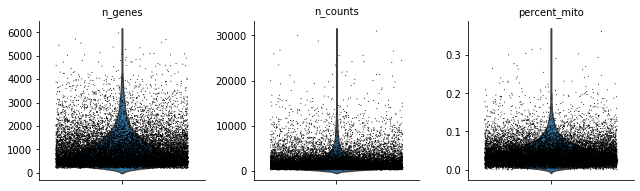

In [5]:
mito_genes=[element for element in adata.var_names if element[:2] == 'mt']
print(mito_genes,len(mito_genes))

adata.obs['percent_mito']=numpy.sum(adata[:,mito_genes].X,axis=1).A1/numpy.sum(adata.X,axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
scanpy.pl.violin(adata,['n_genes','n_counts','percent_mito'],jitter=0.4,multi_panel=True)

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


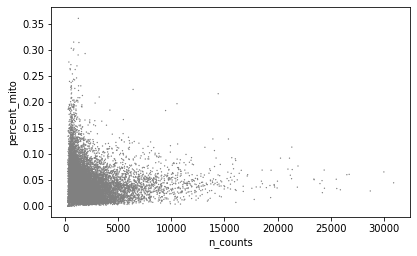

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


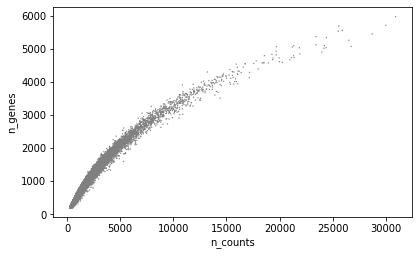

In [6]:
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [7]:
adata

AnnData object with n_obs × n_vars = 16541 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [8]:
print('remove high mito')
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)
print()

remove high mito
View of AnnData object with n_obs × n_vars = 11485 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



8.520520448684692 12.738192319869995
counts lower and upper bounds 367.2249951128508 6832.473859902639
remove low n_count
View of AnnData object with n_obs × n_vars = 11386 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove high n_count
View of AnnData object with n_obs × n_vars = 10940 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



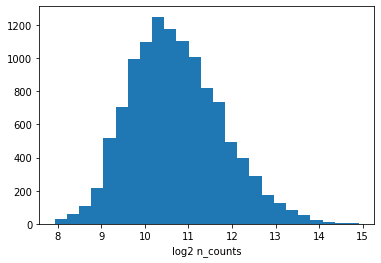

In [9]:
log2counts=numpy.log2(adata.obs['n_counts'])
log2counts.hist(grid=False,bins=25)
matplotlib.pyplot.xlabel('log2 n_counts')

log2LB=log2counts.median()-(2*log2counts.std())
log2UB=log2counts.median()+(2*log2counts.std())
print(log2LB,log2UB)

LB=2**log2LB
UB=2**log2UB
totalUMI=UB
# alternatively 2,000 - open

print('counts lower and upper bounds',LB,UB)

print('remove low n_count')
adata = adata[adata.obs['n_counts'] > LB, :]
print(adata)
print()

print('remove high n_count')
adata = adata[adata.obs['n_counts'] < UB, :]
print(adata)
print()

8.160757314140024 11.305273329231902
counts lower and upper bounds 286.1756901763972 2530.6167674606
remove low n_genes
View of AnnData object with n_obs × n_vars = 10769 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove high n_genes
View of AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



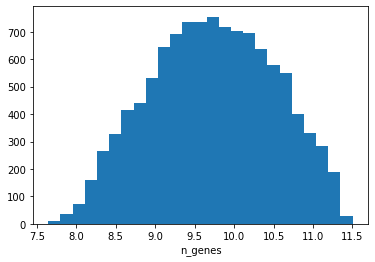

In [10]:
log2genes=numpy.log2(adata.obs['n_genes'])
log2genes.hist(grid=False,bins=25)
matplotlib.pyplot.xlabel('n_genes')

log2LB=log2genes.median()-(2*log2genes.std())
log2UB=log2genes.median()+(2*log2genes.std())
print(log2LB,log2UB)

LB=2**log2LB
UB=2**log2UB
# alternatively 800 - open

print('counts lower and upper bounds',LB,UB)

print('remove low n_genes')
adata = adata[adata.obs['n_genes'] > LB, :]
print(adata)
print()

print('remove high n_genes')
adata = adata[adata.obs['n_genes'] < UB, :]
print(adata)
print()

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


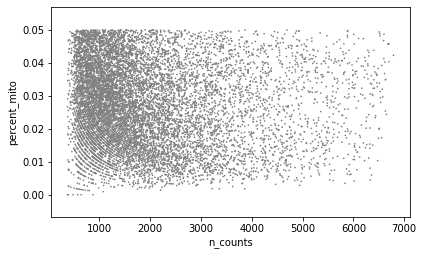

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


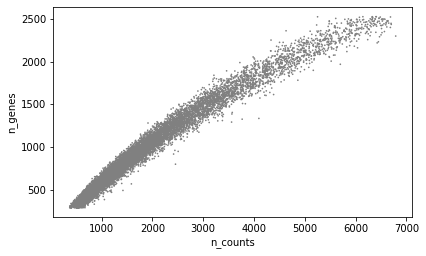

In [11]:
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata

AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [13]:
print(totalUMI)
scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=totalUMI)

6832.473859902639


In [14]:
scanpy.pp.log1p(adata)

In [15]:
adata.raw = adata

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


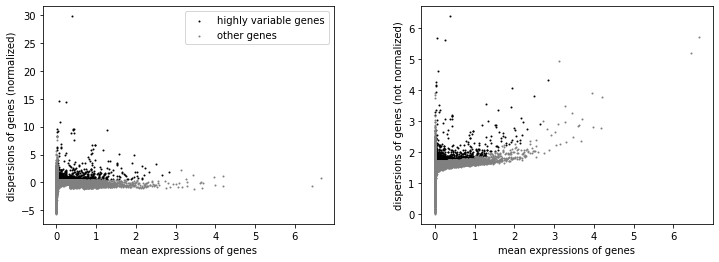

In [16]:
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [18]:
sum(adata.var['highly_variable'])

1425

In [19]:
print(adata)
adata = adata[:,adata.var['highly_variable']]
print(adata)

AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
View of AnnData object with n_obs × n_vars = 10712 × 1425 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [20]:
scanpy.pp.regress_out(adata,['n_counts','percent_mito']) # regress cell cyle!!!!!!!!

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/Users/alomana/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/Users/alomana/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/Users/alomana/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/Users/alomana/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop workin

    finished (0:00:05.89)


In [21]:
scanpy.pp.scale(adata,max_value=10)

# 3. Annotation

In [22]:
cellIDs=adata.obs_names.tolist()

day_labels=[]
for cellID in cellIDs:
    if '-1' in cellID:
        day_labels.append('control_0h')
    elif '-2' in cellID:
        day_labels.append('infected_4h')
    elif '-3' in cellID:
        day_labels.append('infected_24ha')
    elif '-4' in cellID:
        day_labels.append('infected_24hb')
    else:
        print('error!')
        
adata.obs['day_label']=day_labels
print(len(cellIDs),len(day_labels))

a=day_labels.count('control_0h')
b=day_labels.count('infected_4h')
c=day_labels.count('infected_24ha')
d=day_labels.count('infected_24hb')

print(a,b,c,d)

10712 10712
5255 1372 2094 1991


# 4. Visualization

In [23]:
scanpy.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.69)


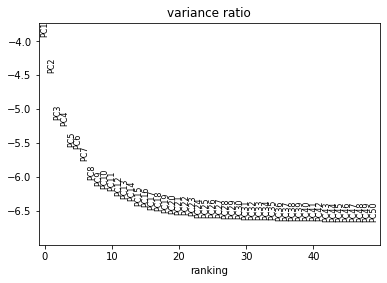

In [24]:
scanpy.pl.pca_variance_ratio(adata,log=True,n_pcs=50)

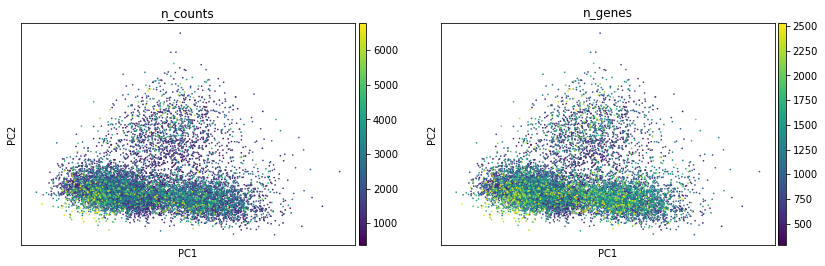

In [35]:
scanpy.pl.pca(adata,color=['n_counts','n_genes'],palette='viridis')

In [27]:
scanpy.tl.tsne(adata,n_pcs=40,n_jobs=8)

computing tSNE
    using 'X_pca' with n_pcs = 40
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:00.67) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


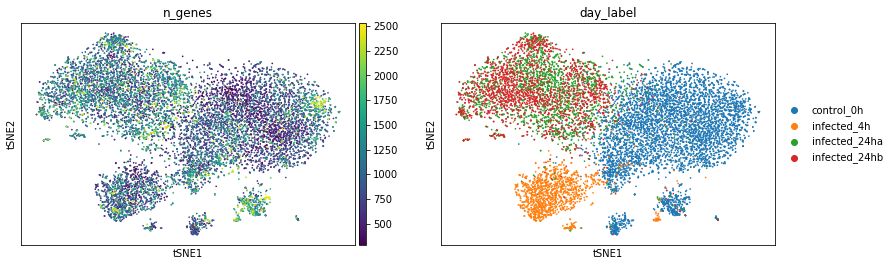

In [28]:
scanpy.pl.tsne(adata,color=['n_genes','day_label'])

In [47]:
scanpy.pp.neighbors(adata,n_neighbors=15,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
scanpy.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:03.31) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:05.80) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.74) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
running Leiden clustering
    finished (0:00:03.23) --> found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


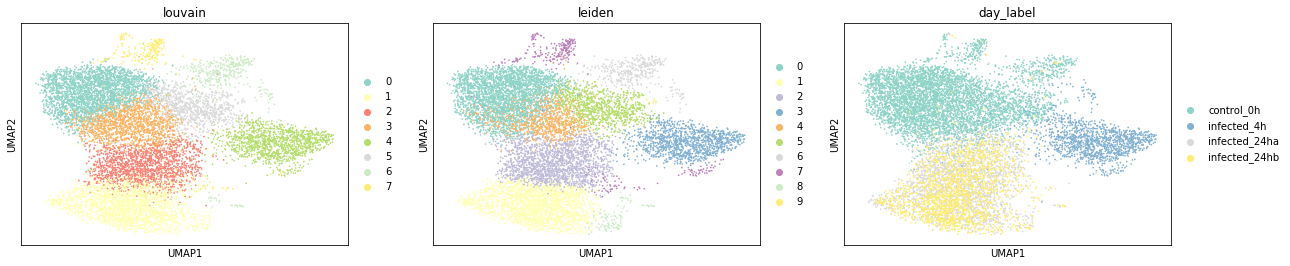

In [58]:
scanpy.pl.umap(adata, color=['louvain','leiden','day_label'],palette='Set3')

ranking genes
    finished (0:00:11.74) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


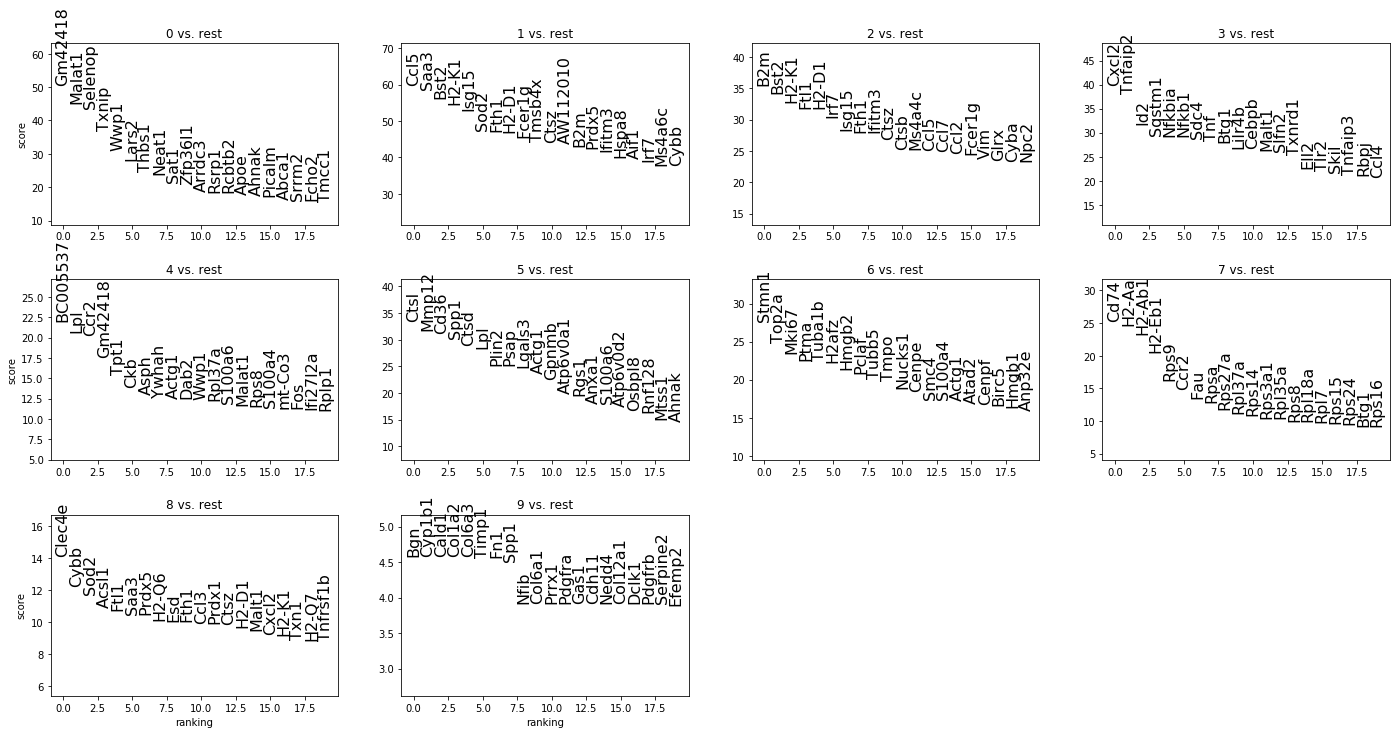

In [59]:
scanpy.tl.rank_genes_groups(adata,'leiden',method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=20, sharey=False,fontsize=16)

ranking genes
    finished (0:00:10.37) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


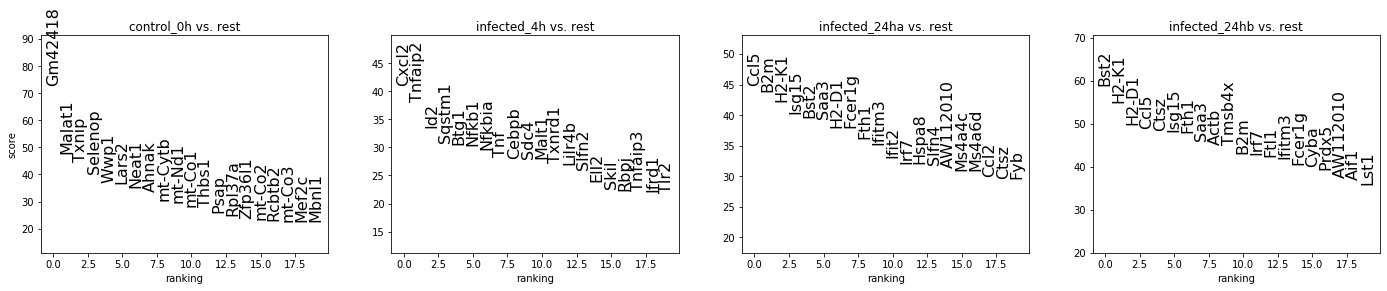

In [60]:
scanpy.tl.rank_genes_groups(adata,'day_label',method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=20, sharey=False,fontsize=16)

In [50]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(25)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,4_l,5_n,5_p,5_l,6_n,6_p,6_l,7_n,7_p,7_l
0,Gm42418,0.000000e+00,1.338550,Ccl5,0.000000e+00,5.181322,B2m,3.653632e-259,1.367260,Gm42418,...,5.588000,Ctsl,2.994599e-234,2.185206,Stmn1,8.348971e-153,5.664405,Cd74,1.637060e-105,6.931802
1,Selenop,0.000000e+00,2.264099,Saa3,0.000000e+00,6.035695,Bst2,6.546359e-248,2.034703,BC005537,...,3.199448,Mmp12,2.626567e-217,4.043509,Top2a,3.109774e-127,6.360749,H2-Aa,2.043181e-96,7.133434
2,Malat1,0.000000e+00,0.868929,Bst2,0.000000e+00,2.980727,H2-K1,3.624593e-235,1.328185,mt-Co1,...,2.909175,Spp1,1.193686e-211,2.786342,Mki67,1.412936e-111,6.417123,H2-Ab1,4.904782e-90,6.805125
3,Txnip,1.508368e-293,1.951867,H2-K1,0.000000e+00,1.973323,H2-D1,2.593259e-225,1.257705,Lpl,...,2.493621,Cd36,7.131250e-207,2.324550,Tuba1b,7.590655e-106,2.606281,H2-Eb1,4.820023e-66,7.441208
4,Wwp1,1.298592e-195,1.668821,Isg15,0.000000e+00,3.466730,Ftl1,2.188326e-199,0.872821,mt-Co3,...,2.554556,Ctsd,5.049871e-181,1.168172,H2afz,3.900549e-105,2.974406,Rps9,8.388996e-57,1.696838
5,Thbs1,1.511423e-144,1.732684,Fth1,0.000000e+00,1.733886,Irf7,6.555028e-193,1.902772,mt-Co2,...,2.549425,Lpl,6.462759e-179,2.175204,Ptma,2.335753e-101,1.908017,Ccr2,3.766043e-56,3.784259
6,Lars2,2.901965e-137,0.933716,Sod2,0.000000e+00,3.554890,Isg15,5.058033e-192,2.182390,Tpt1,...,2.629703,Lgals3,5.908333e-138,1.588806,Hmgb2,4.458793e-96,3.740239,Fau,2.247427e-37,1.351472
7,Sat1,1.873714e-112,1.147836,H2-D1,0.000000e+00,1.663217,Fth1,1.254752e-175,1.156188,Lars2,...,3.486031,Psap,5.322363e-137,0.784082,Pclaf,9.539294e-89,6.718758,Rpsa,1.941148e-34,1.507250
8,Zfp36l1,1.071490e-110,1.570124,Fcer1g,0.000000e+00,2.289674,Ifitm3,1.114082e-167,1.653296,mt-Nd1,...,2.077193,Plin2,4.978574e-134,1.700322,Tubb5,2.409793e-86,2.676603,Rps27a,2.367851e-30,1.134715
9,Neat1,4.192096e-106,0.816190,Ctsz,0.000000e+00,2.167656,Ctsz,1.768207e-157,1.469446,Wwp1,...,1.817279,Actg1,2.026742e-127,1.810374,Tmpo,4.214957e-79,3.788462,Rpl37a,7.303532e-29,1.117344


ranking genes
    finished (0:00:02.81) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


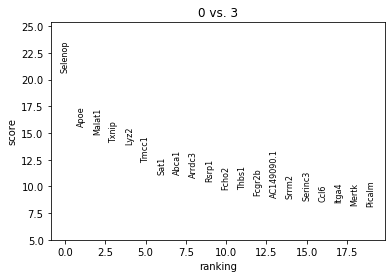

In [54]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='3', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

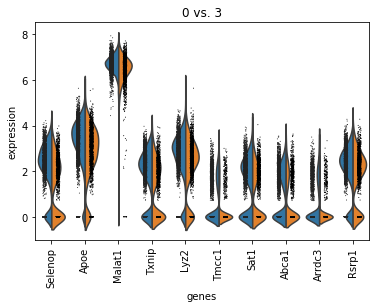

In [55]:
scanpy.pl.rank_genes_groups_violin(adata, groups='0', n_genes=10)